In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ipywidgets import interact

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FIXED_NOISE = torch.randn(64, 100, 1, 1, device=DEVICE)

In [4]:
def weights_init(m: nn.Module):
    classname = m.__class__.__name__
    if "Conv" in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif "BatchNorm" in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [5]:
class GeneratorCGAN(nn.Module):
    def __init__(self, nz: int, num_classes: int):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz + num_classes, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        y = self.label_emb(labels).unsqueeze(2).unsqueeze(3)  # (N, C,1,1)
        z = torch.cat([z, y], dim=1)
        return self.main(z)

In [6]:
class DiscriminatorCGAN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 7, 1, bias=False)
        self.embed = nn.Embedding(num_classes, 128 * 7 * 7)
    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        h = self.features(x)
        h_flat = self.flatten(h)
        out = self.fc(h_flat)
        proj = torch.sum(self.embed(labels) * h_flat, dim=1, keepdim=True)
        return out + proj

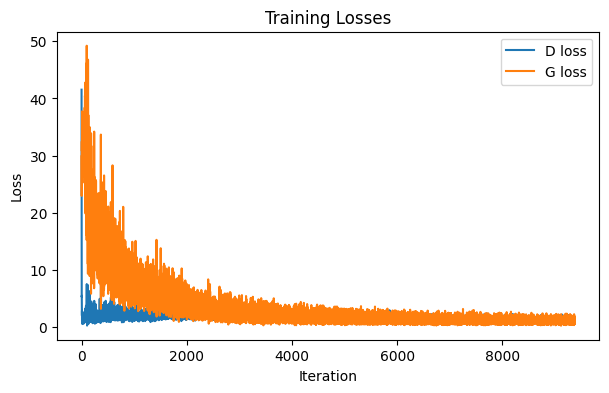

Finished training!


In [11]:
epochs = 20
batch_size = 128
lr = 0.0002
beta1 = 0.5  # Adam β1
nz = 100  # Latent vector size
num_classes = 10  # Digits 0-9



transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

netG = GeneratorCGAN(nz, num_classes).to(DEVICE)
netD = DiscriminatorCGAN(num_classes).to(DEVICE)
netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()
optD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

d_history, g_history, grids = [], [], []

for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(loader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        bs = imgs.size(0)
        real_lbl = torch.ones(bs, 1, device=DEVICE)
        fake_lbl = torch.zeros(bs, 1, device=DEVICE)

        optD.zero_grad()
        out_real = netD(imgs, labels)
        loss_real = criterion(out_real, real_lbl)

        z = torch.randn(bs, nz, 1, 1, device=DEVICE)
        fake_imgs = netG(z, labels)
        out_fake = netD(fake_imgs.detach(), labels)
        loss_fake = criterion(out_fake, fake_lbl)

        d_loss = loss_real + loss_fake
        d_loss.backward()
        optD.step()

        optG.zero_grad()
        out_fake = netD(fake_imgs, labels)
        g_loss = criterion(out_fake, real_lbl)
        g_loss.backward()
        optG.step()

        d_history.append(d_loss.item())
        g_history.append(g_loss.item())

        if i % 100 == 0:
            print(f"[E{epoch + 1}/{epochs}] [{i}/{len(loader)}] D: {d_loss.item():.3f} | G: {g_loss.item():.3f}")

    with torch.no_grad():
            lbls = torch.arange(64, device=DEVICE) % num_classes
            grid = make_grid(netG(FIXED_NOISE, lbls).cpu(), nrow=8, normalize=True)
            grids.append(grid.permute(1,2,0).numpy())
            clear_output(wait=True)
            plt.figure(figsize=(6,6))
            plt.imshow(grids[-1], cmap='gray')
            plt.title(f'Epoch {epoch+1}')
            plt.axis('off')
            display(plt.gcf())
            plt.close()

plt.figure(figsize=(7, 4))
plt.plot(d_history, label='D loss')
plt.plot(g_history, label='G loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()

print('Finished training!')

In [12]:
def show_epoch(e=0):
    if e<0 or e>=len(grids):
        return 'epoch index out of range'
    plt.figure(figsize=(6,6)); plt.imshow(grids[e], cmap='gray'); plt.title(f'Epoch {e+1}'); plt.axis('off')
    plt.show()


interact(show_epoch, e=(0, len(grids)-1))

interactive(children=(IntSlider(value=0, description='e', max=19), Output()), _dom_classes=('widget-interact',…

<function __main__.show_epoch(e=0)>